In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-delays/airports.csv
/kaggle/input/flight-delays/airlines.csv
/kaggle/input/flight-delays/flights.csv


In [2]:
import catboost as cab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_curve,auc,f1_score,accuracy_score,\
    precision_recall_curve,classification_report,average_precision_score,roc_auc_score,make_scorer

In [3]:
data = pd.read_csv('/kaggle/input/flight-delays/flights.csv')
data = data[["MONTH", "DAY", "DAY_OF_WEEK", "AIRLINE", "FLIGHT_NUMBER", "DESTINATION_AIRPORT",
             "ORIGIN_AIRPORT", "AIR_TIME", "DEPARTURE_TIME", "DISTANCE", "ARRIVAL_DELAY"]]

/tmp/ipykernel_19/797934292.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/kaggle/input/flight-delays/flights.csv')


In [4]:
pd.isnull(data).values.any()

True

In [5]:
#删除缺失值
data.dropna(inplace=True)

In [6]:
pd.isnull(data).values.any()

False

In [7]:
#提取20%的数据
data = data.sample(frac = 0.2,random_state = 10)

In [8]:
#将到达延误情况转化为二值变量
data['ARRIVAL_DELAY'] = (data['ARRIVAL_DELAY'] > 10)*1
# 计算不同取值的频数
value_counts = data['ARRIVAL_DELAY'].value_counts()

# 计算两个类别的样本数量差距
class_diff = value_counts[0] - value_counts[1]

# 根据样本数量差距抽样
if class_diff > 0:
    # 如果类别0的样本数量多，抽取与类别1一样多的样本
    sampled_data = data[data['ARRIVAL_DELAY'] == 0].sample(n=value_counts[1], random_state=10)
    data = pd.concat([sampled_data, data[data['ARRIVAL_DELAY'] == 1]])
else:
    # 如果类别1的样本数量多，抽取与类别0一样多的样本
    sampled_data = data[data['ARRIVAL_DELAY'] == 1].sample(n=value_counts[0], random_state=10)
    data = pd.concat([sampled_data, data[data['ARRIVAL_DELAY'] == 0]])

In [9]:
len(data)

502458

In [10]:
#将航线、航班号、到达机场、出发机场进行one-hot编码
cols = ['AIRLINE', 'FLIGHT_NUMBER', 'DESTINATION_AIRPORT', 'ORIGIN_AIRPORT']
for item in cols:
    data[item] = data[item].astype('category').cat.codes + 1

#将数据集按照7:3拆分为训练集和测试集
x_train,x_test,y_train,y_test = train_test_split(data.drop(['ARRIVAL_DELAY'],axis = 1),
                                                 data['ARRIVAL_DELAY'],random_state = 10,train_size = 0.70)

# ****探索性分析

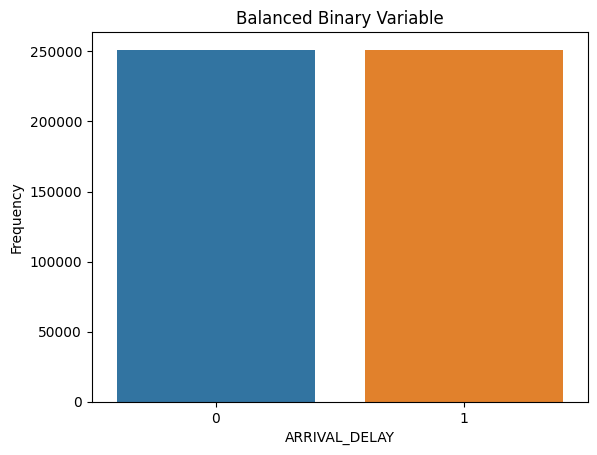

In [11]:
import seaborn as sns
arrival_delay = data['ARRIVAL_DELAY']
value_counts = arrival_delay.value_counts()

# 绘制柱状图
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('ARRIVAL_DELAY')
plt.ylabel('Frequency')
plt.title('Balanced Binary Variable')
plt.show()

In [12]:
data[['AIR_TIME', 'DEPARTURE_TIME','DISTANCE']].describe()

,AIR_TIME,DEPARTURE_TIME,DISTANCE
count,502458.000000,502458.000000,502458.000000
mean,115.087414,1397.188806,828.863913
std,72.941869,500.618763,608.117459
min,8.000000,1.000000,31.000000
25%,61.000000,1006.000000,376.000000
50%,96.000000,1423.000000,666.000000
75%,146.000000,1818.000000,1069.000000
max,690.000000,2400.000000,4983.000000


array([[<Axes: title={'center': 'AIRLINE'}>,
        <Axes: title={'center': 'FLIGHT_NUMBER'}>],
       [<Axes: title={'center': 'DESTINATION_AIRPORT'}>,
        <Axes: title={'center': 'AIR_TIME'}>],
       [<Axes: title={'center': 'DEPARTURE_TIME'}>,
        <Axes: title={'center': 'DISTANCE'}>]], dtype=object)

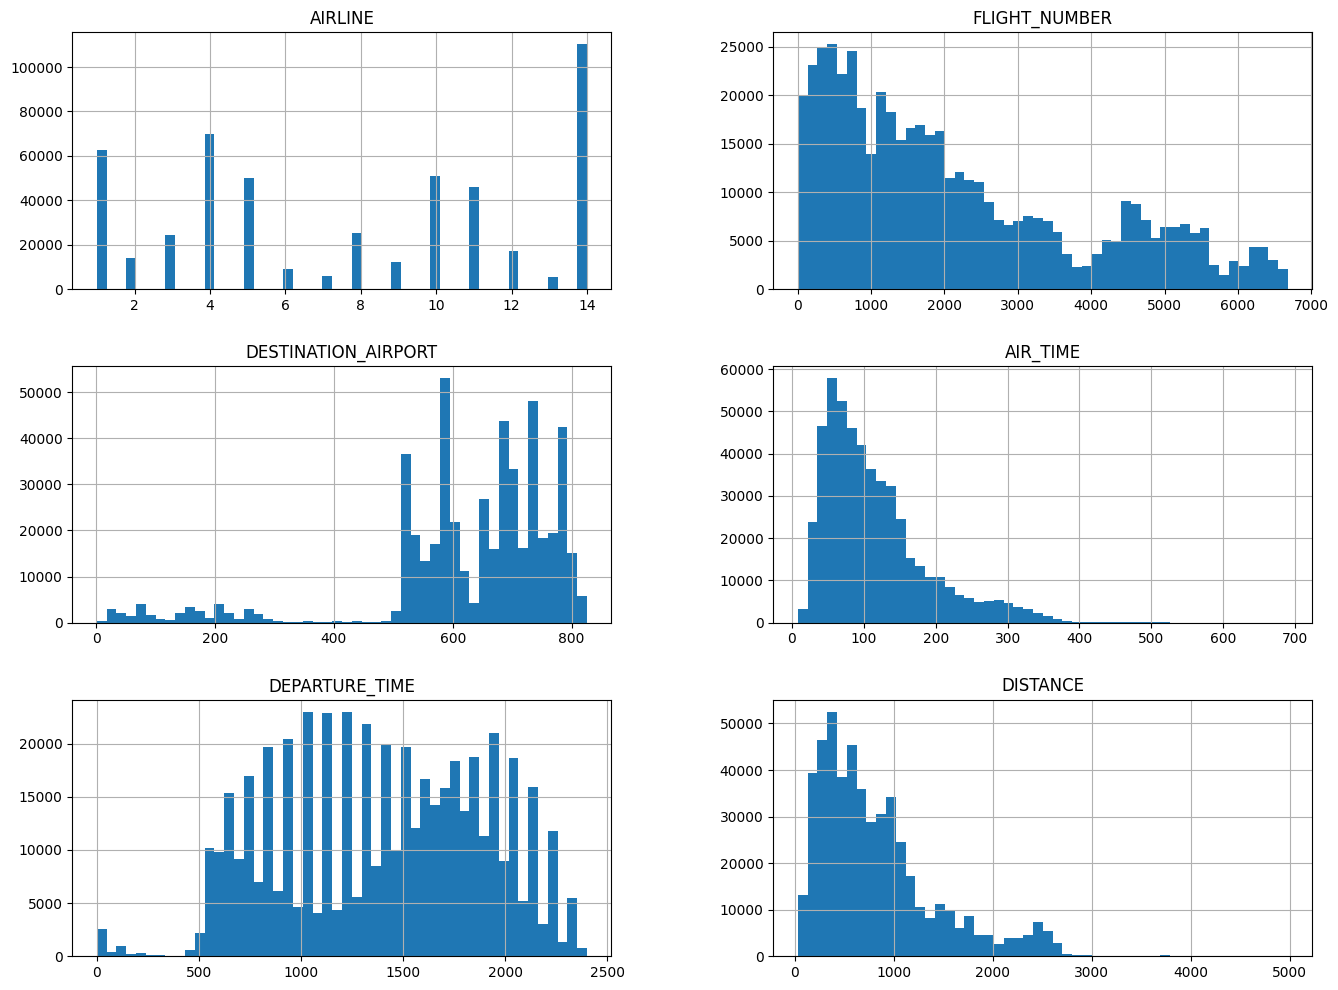

In [13]:
data[['AIRLINE', 'FLIGHT_NUMBER', 'DESTINATION_AIRPORT','AIR_TIME', 'DEPARTURE_TIME','DISTANCE']].hist(bins=50,figsize=(16,12))

# ****Xgboost

In [14]:
import xgboost as xgb
SEED=123456

In [15]:
class XGBParamSearch:
    def __init__(self, parameters, scoring='accuracy', cv=4):
        self.parameters = parameters
        self.scoring = scoring
        self.cv = cv
        self.model = None
        self.best_params_ = None

    def fit(self, x_train, y_train):
        try:
            self.model = GridSearchCV(
                xgb.XGBClassifier(
                    objective='binary:logistic',
                    booster="gbtree",
                    verbosity=0,
                    scale_pos_weight=len(y_train) / sum(y_train) - 1,
                    eval_metric='auc',
                    random_state=SEED,
                    subsample=0.8,
                    reg_alpha=0.3
                ),
                param_grid=self.parameters,
                scoring=self.scoring,
                refit='AUC',
                cv=self.cv,
                return_train_score=True
            )
            self.model.fit(x_train, y_train)
            self.best_params_ = self.model.best_params_
        except Exception as e:
            print("An error occurred during parameter search:", str(e))

        return self.best_params_

# 使用示例
parameters = {
    'n_estimators': range(100, 400, 100),
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.8]
}

param_search = XGBParamSearch(parameters, scoring='roc_auc', cv=4)
best_params = param_search.fit(x_train, y_train)
print("Best parameters:", best_params)

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [16]:
#使用最优参数组合建模
#Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}

import xgboost as xgb
from time import time
SEED = 10
model_XGB = xgb.XGBClassifier(objective = 'binary:logistic',
                              booster = "gbtree",verbosity = 0,
                              scale_pos_weight = len(y_train)/sum(y_train)-1,
                              eval_metric = 'auc', random_state = SEED,
                              subsample = 0.8,reg_alpha = 0.3,
                              colsample_bytree=0.8, learning_rate= 0.1, 
                              max_depth= 7, n_estimators = 300)
t = time()
model_XGB.fit(x_train,y_train)
print('时间：',round(time()-t,4)) # 拟合模型运行时间
print('XGBoost模型结果评价-训练集：\n',classification_report(y_train,model_XGB.predict(x_train),digits=4))
print('XGBoost模型结果评价-测试集：\n',classification_report(y_test,model_XGB.predict(x_test),digits=4))

时间： 6.7961
XGBoost模型结果评价-训练集：
               precision    recall  f1-score   support

           0     0.7121    0.7332    0.7225    175926
           1     0.7248    0.7034    0.7140    175794

    accuracy                         0.7183    351720
   macro avg     0.7185    0.7183    0.7182    351720
weighted avg     0.7185    0.7183    0.7182    351720

XGBoost模型结果评价-测试集：
               precision    recall  f1-score   support

           0     0.6804    0.7037    0.6919     75303
           1     0.6938    0.6701    0.6817     75435

    accuracy                         0.6869    150738
   macro avg     0.6871    0.6869    0.6868    150738
weighted avg     0.6871    0.6869    0.6868    150738



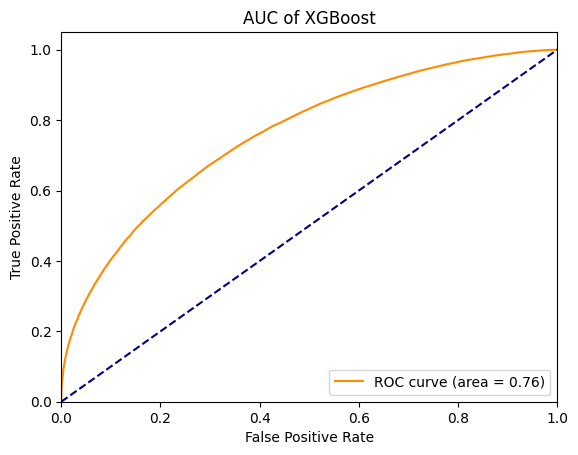

In [17]:
y_pred_XGB = model_XGB.predict_proba(x_test)[:, 1]  # 获取正类的概率预测值

# 计算TPR和FPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_XGB)

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC of XGBoost')
plt.legend(loc="lower right")
plt.show()

# ****Catboost

In [18]:
#类别变量对应的列
cat_features_index = [0,1,2,3,4,5,6]
#设置种子
SEED = 10

In [19]:
import catboost as cab
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

class CatBoostParamSearch:
    def __init__(self, parameters, scoring='accuracy', cv=4):
        self.parameters = parameters
        self.scoring = scoring
        self.cv = cv
        self.model = None
        self.best_params_ = None

    def fit(self, x_train, y_train):
        try:
            self.model = GridSearchCV(
                cab.CatBoostClassifier(random_seed=SEED,verbose=False),
                param_grid=self.parameters,
                scoring=self.scoring,
                refit='AUC',
                cv=self.cv,
                return_train_score=True
            )
            self.model.fit(x_train, y_train)
            self.best_params_ = self.model.best_params_
        except Exception as e:
            print("An error occurred during parameter search:", str(e))

        return self.best_params_

# 使用示例
parameters = {
    'depth': [4, 7, 10],
    'learning_rate': [0.03, 0.1, 0.15],
    'l2_leaf_reg': [1, 4, 9],
    'iterations': [300, 500]
}

param_search = CatBoostParamSearch(parameters, scoring=make_scorer(roc_auc_score), cv=4)
best_params = param_search.fit(x_train, y_train)
print("Best parameters:", best_params)

Best parameters: {'depth': 10, 'iterations': 500, 'l2_leaf_reg': 9, 'learning_rate': 0.15}


In [20]:
#用最优参数拟合数据
#Best parameters: {'depth': 10, 'iterations': 500, 'l2_leaf_reg': 9, 'learning_rate': 0.15}
from time import time
model_CaB = cab.CatBoostClassifier(random_seed = SEED,depth = 10,iterations = 500,
l2_leaf_reg = 9,learning_rate = 0.15,verbose=False)
t = time()
model_CaB.fit(x_train,y_train,cat_features = cat_features_index)
print('时间：',round(time()-t,4)) # 拟合模型运行时间
print('CatBoost模型结果评价-训练集：\n',classification_report(y_train,model_CaB.predict(x_train),digits=4))
print('CatBoost模型结果评价-测试集：\n',classification_report(y_test,model_CaB.predict(x_test),digits=4))

时间： 520.0134
CatBoost模型结果评价-训练集：
               precision    recall  f1-score   support

           0     0.9511    0.9241    0.9374    175926
           1     0.9262    0.9525    0.9391    175794

    accuracy                         0.9383    351720
   macro avg     0.9386    0.9383    0.9383    351720
weighted avg     0.9387    0.9383    0.9383    351720

CatBoost模型结果评价-测试集：
               precision    recall  f1-score   support

           0     0.7272    0.8149    0.7686     75303
           1     0.7899    0.6948    0.7393     75435

    accuracy                         0.7548    150738
   macro avg     0.7586    0.7549    0.7539    150738
weighted avg     0.7586    0.7548    0.7539    150738



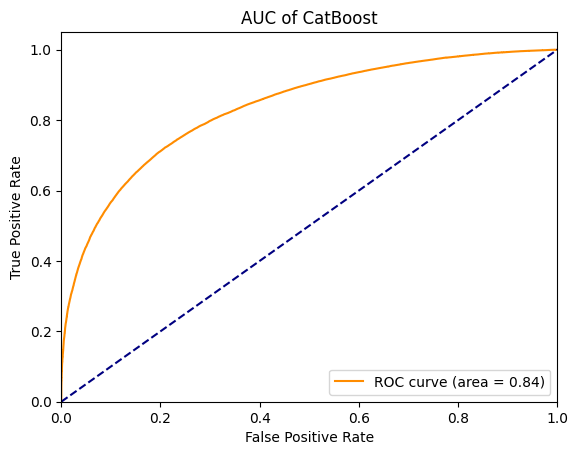

In [21]:
y_pred_CaB =  model_CaB.predict_proba(x_test)[:, 1]  # 获取正类的概率预测值

# 计算TPR和FPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_CaB)

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC of CatBoost')
plt.legend(loc="lower right")
plt.show()

#绘制特征重要性条形图
value = model_CaB.feature_importances_
feature = model_CaB.feature_names_
plt.figure(figsize = (16,9))
plt.barh(feature,value,height = 0.5)
plt.show()

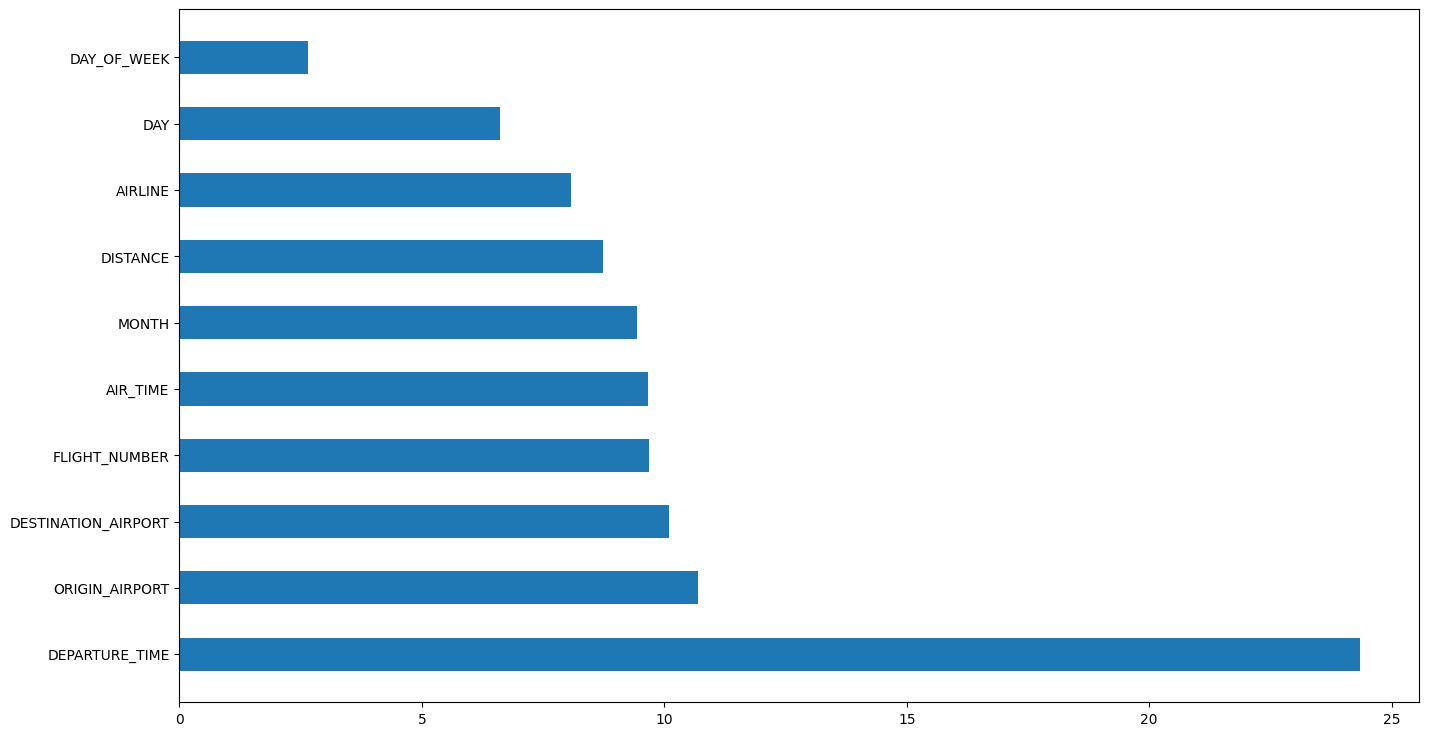

In [22]:
# 获取特征重要性的索引并按重要性降序排列
feature = model_CaB.feature_names_
importance_index = model_CaB.feature_importances_.argsort()[::-1]
sorted_values = model_CaB.feature_importances_[importance_index]
sorted_feature = [feature[i] for i in importance_index]

# 绘制特征重要性条形图
plt.figure(figsize=(16, 9))
plt.barh(sorted_feature, sorted_values, height=0.5)
plt.show()
